In [2]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [3]:
np.random.seed(2020)

## Load Datasets


In [143]:
class SimilarityPreprocessing(Preprocessing):
    def __init__(self,dataset,numOfDatapoints):
        super().__init__(dataset)
        self.num_of_datapoints = numOfDatapoints
        
    def _feature_engineering(self):
        super()._feature_engineering()
        
        ## create similarity points
        indices = np.argwhere(self.y).flatten()
        np.random.shuffle(indices)
        indices = indices[:self.num_of_datapoints]        
        X = np.array(self.original_dataset.tolist()) # make unstructured, not very efficient..
        X = X[:,2:] # remove IDs and '?' of predictions
        dataset = self.dataset
        for index in indices:
            datapoint =  self.dataset[index]
            similarity = self.similarity(datapoint,X)
            dataset = np.concatenate((dataset,similarity),axis=1)
        self.dataset = dataset
    def similarity(self, point, X):
        sim  = np.sum((X-point)**2,axis=1)
        sim = (sim) /np.std(sim)        
        return np.exp(-sim).reshape((-1,1))

class AddFeaturesPreprocessing(Preprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
    def _feature_engineering(self):
        
        X = np.array(self.original_dataset.tolist()) # make unstructured, not very efficient..
        X = X[:,2:] # remove IDs and '?' of predictions
        col = X[:,1]
        f1 = col = 1-np.exp(-col**2/5000).reshape((-1,1))
        self.dataset = np.concatenate((self.dataset,f1),axis=1)


In [144]:
## SIMILARITY FEATURES
#p = SimilarityPreprocessing(load_csv('../dataset/trainset.csv'),100)
#y_train , x_train= p.preprocess()
#p = SimilarityPreprocessing(load_csv('../dataset/testset.csv'),100)
#y_test, x_test = p.preprocess()

## new feature
p = AddFeaturesPreprocessing(load_csv('../dataset/trainset.csv'))
y_train , x_train= p.preprocess()
p = AddFeaturesPreprocessing(load_csv('../dataset/testset.csv'))
y_test, x_test = p.preprocess()

In [146]:
print(x_train.shape)
print(x_test.shape)


(225000, 32)
(25000, 32)


## Prediction with decision boundary

In [147]:
def predict(weight, x_test, boundary = 0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = x_test.dot(weight)
    return (pred > boundary)*1
    

## Ridge Regression on dataset

In [148]:
w, loss = ridge_regression(y_train, x_train,0.0000001)
print(w) # gives an idea about the important columns.. 
print(w.shape)
print(loss)

[ 5.75725621e-01  1.72734738e-02  5.54636715e-02 -1.30381013e-01
  1.85287970e-02  1.10711473e-02  4.48984856e-02  3.58670944e-03
  1.30488873e-01 -1.67235166e-02  7.19010404e-03 -8.60182082e-02
  4.65995897e-02  3.80604657e-02  8.17276652e-02  2.32468829e-04
 -2.62906129e-04  1.17592527e-01 -1.05715059e-03  7.43055708e-04
  3.50422888e-02  3.13542902e-04 -2.06751943e-02  2.01959127e-02
 -2.01702019e-02  1.19745030e-04 -4.56299509e-05 -1.61650152e-02
  2.53759252e-04 -3.09710949e-04 -1.03772775e-02 -6.08822146e-01]
(32,)
0.08384294650750951


##  Cross Validation

In [149]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K, _lambda):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)

        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] = ridge_regression(y_train, x_train,_lambda)
        test_loss[i] = compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

0.7482


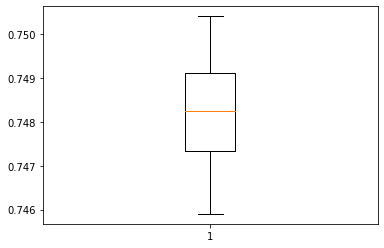

In [150]:
accs,test_loss, train_loss, w = K_Cross_Validation(x_train,y_train,4,0.001)
plt.boxplot(accs)
print(accs.mean())

## Tune Hyperparameters

In [151]:
def Tune_lambda(xt_training, y_training, K, gamma_range):
        
    gammas = np.logspace(-7, gamma_range, 20)
    min_loss = np.inf
    opt_lambda = 0
    opt_index = 0
    accuracies = []
    train_losses = []
    test_losses = []
    for i, lambda_ in enumerate(gammas):
       
        accuracy,test,train,w = K_Cross_Validation(xt_training, y_training, K,lambda_)
        accuracies.append([lambda_,accuracy.mean()])
        train_losses.append([lambda_,train.mean()])
        test_losses.append([lambda_,test.mean()])
        if (test.mean() < min_loss):
            min_loss = test.mean()
            opt_lambda = lambda_
            opt_index = i
                
    return opt_lambda , min_loss, np.array(accuracies), np.array(train_losses), np.array(test_losses), opt_index
opt_lambda, min_loss, acc ,train, test, opt_index= Tune_lambda(x_train, y_train, 5, 1)

print(f"optimal loss = {min_loss} with lambda= {opt_lambda}")
print(f"accuracy = {acc[opt_index][1]}")

optimal loss = 0.0838707422420909 with lambda= 6.951927961775605e-07
accuracy = 0.7494488888888888


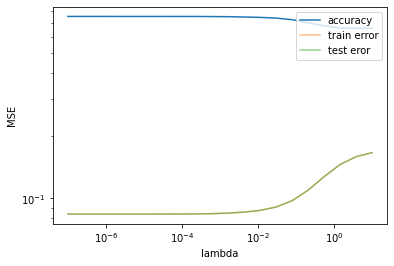

In [152]:

plt.plot(acc[:,0],acc[:,1], label="accuracy")
plt.plot(train[:,0],train[:,1],alpha=0.5,label="train error")
plt.plot(test[:,0],test[:,1],alpha=0.5, label = "test eror")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.show()

model is clearly **UNDERFITTING**, test and train score are exactly the same and increasing

## predictions on test set 

In [153]:
w_opt,loss = ridge_regression(y_train,x_train,opt_lambda)
p = predict(w_opt,x_test)
print((p==y_test).mean())

0.7536


In [154]:
w_opt

array([ 5.75670943e-01,  1.72701759e-02,  5.54210547e-02, -1.30379520e-01,
        1.85243125e-02,  1.10716915e-02,  4.48981885e-02,  3.58666272e-03,
        1.30490082e-01, -1.67228683e-02,  1.78341452e-02, -8.60188145e-02,
        4.66024690e-02,  3.80604218e-02,  7.96690951e-02,  2.32457982e-04,
       -2.62922353e-04,  1.15566879e-01, -1.05710369e-03,  7.43056177e-04,
        3.50461595e-02,  3.13586083e-04, -2.06755498e-02,  2.01953112e-02,
       -2.01713567e-02,  1.19781253e-04, -4.56486394e-05, -1.61655867e-02,
        2.53808579e-04, -3.09698564e-04, -1.93907997e-02, -6.08681144e-01])